In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from numba import njit
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from scipy.stats import kstest
import numpy.random
import seaborn as sns
import matplotlib.pyplot as plt
from DataAccessor import DataAccessor
from Features import Features
from tqdm.auto import tqdm

In [3]:
sns.set(style="darkgrid")

In [4]:
data_path = Path('data')

In [5]:
df_train = pd.read_csv(data_path / 'train.csv')

In [6]:
df_test = pd.read_csv(data_path / 'test.csv')

In [7]:
df_train.rename(columns={"opened_position_qty ": "opened_position_qty"}, inplace=True)
df_test.rename(columns={"opened_position_qty ": "opened_position_qty"}, inplace=True)

In [8]:
y = df_train.pop('y')

In [9]:
df_train.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,8,1,6,14,6,6,1,1,10,2
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,7,6,11,1,6,1,4,4,1,13
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,3,1,4,21,12,1,16,10,4,9
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,10,13,12,2,4,2,7,1,2,11
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,14,12,2,2,4,1,3,1,11,15


In [10]:
df_test.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
0,592380,5178.4,5178.3,1.0,11.0,12.0,-10,5178.2,5178.0,5177.8,...,3,16,3,1,1,1,4,1,5,2
1,592381,5133.0,5132.9,1.0,0.0,1.0,1,5132.8,5132.6,5132.4,...,1,2,2,1,10,4,8,1,1,1
2,592382,5177.4,5178.0,2.0,0.0,2.0,2,5177.2,5176.8,5176.6,...,8,18,1,1,6,7,4,1,2,5
3,592383,5093.6,5093.9,0.0,2.0,2.0,-1,5093.2,5093.0,5092.8,...,8,5,4,3,1,1,1,11,6,2
4,592384,5189.2,5189.2,NaN,NaN,0.0,0,5188.8,5188.6,5188.4,...,1,5,1,3,3,3,2,1,3,4


In [11]:
df_train.describe()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
count,592380.000000,592380.000000,592380.000000,419920.000000,419920.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,...,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000
mean,296189.500000,3965.639532,3965.639078,1.400583,1.964277,2.390106,-0.080745,3965.446863,3965.209031,3964.985168,...,3.831917,4.906759,5.314979,5.601242,5.930859,3.887878,4.913441,5.309274,5.611319,5.927790
std,171005.520569,81.801597,81.801148,2.262542,2.612520,3.781083,2.349781,81.795678,81.789472,81.783336,...,4.269410,5.098520,5.411883,5.731617,6.256011,4.505598,5.432179,5.920962,6.505823,6.975328
min,0.000000,3812.000000,3812.100000,0.000000,0.000000,0.000000,-171.000000,3811.800000,3811.600000,3811.400000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,148094.750000,3896.400000,3896.400000,0.000000,1.000000,0.000000,-1.000000,3896.200000,3896.000000,3895.800000,...,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000
50%,296189.500000,3983.800000,3983.700000,1.000000,1.000000,1.000000,0.000000,3983.600000,3983.200000,3983.000000,...,2.000000,3.000000,4.000000,4.000000,4.000000,2.000000,3.000000,4.000000,4.000000,4.000000
75%,444284.250000,4039.600000,4039.500000,2.000000,2.000000,3.000000,1.000000,4039.400000,4039.000000,4038.800000,...,5.000000,6.000000,7.000000,7.000000,7.000000,5.000000,6.000000,6.000000,7.000000,7.000000
max,592379.000000,4115.800000,4116.000000,80.000000,212.000000,311.000000,50.000000,4115.800000,4115.600000,4115.000000,...,110.000000,139.000000,136.000000,119.000000,120.000000,130.000000,132.000000,133.000000,134.000000,135.000000


In [12]:
df_test.describe()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,bid1vol,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol
count,191859.000000,191859.000000,191859.000000,138203.000000,138203.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,...,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000
mean,688309.000000,5181.363759,5181.362586,1.444629,1.936579,2.439682,-0.026358,5181.074208,5180.750315,5180.449014,...,2.969170,3.277370,3.379940,3.491001,3.636624,3.024951,3.392768,3.581276,3.755638,4.032081
std,55385.066986,46.449903,46.450472,2.182750,2.414769,3.548308,2.291210,46.444242,46.436716,46.428939,...,3.847185,4.154986,4.446168,4.678132,5.001578,4.002970,4.558632,4.929816,5.310623,5.989726
min,592380.000000,5069.400000,5069.100000,0.000000,0.000000,0.000000,-66.000000,5068.600000,5068.200000,5068.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,640344.500000,5149.000000,5149.100000,0.000000,1.000000,0.000000,-1.000000,5148.800000,5148.400000,5148.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,688309.000000,5176.200000,5176.200000,1.000000,1.000000,1.000000,0.000000,5175.800000,5175.600000,5175.200000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,736273.500000,5224.400000,5224.400000,2.000000,2.000000,3.000000,1.000000,5224.200000,5223.800000,5223.400000,...,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000
max,784238.000000,5278.800000,5278.700000,56.000000,69.000000,138.000000,46.000000,5278.600000,5277.800000,5277.600000,...,120.000000,121.000000,121.000000,121.000000,119.000000,98.000000,106.000000,108.000000,113.000000,113.000000


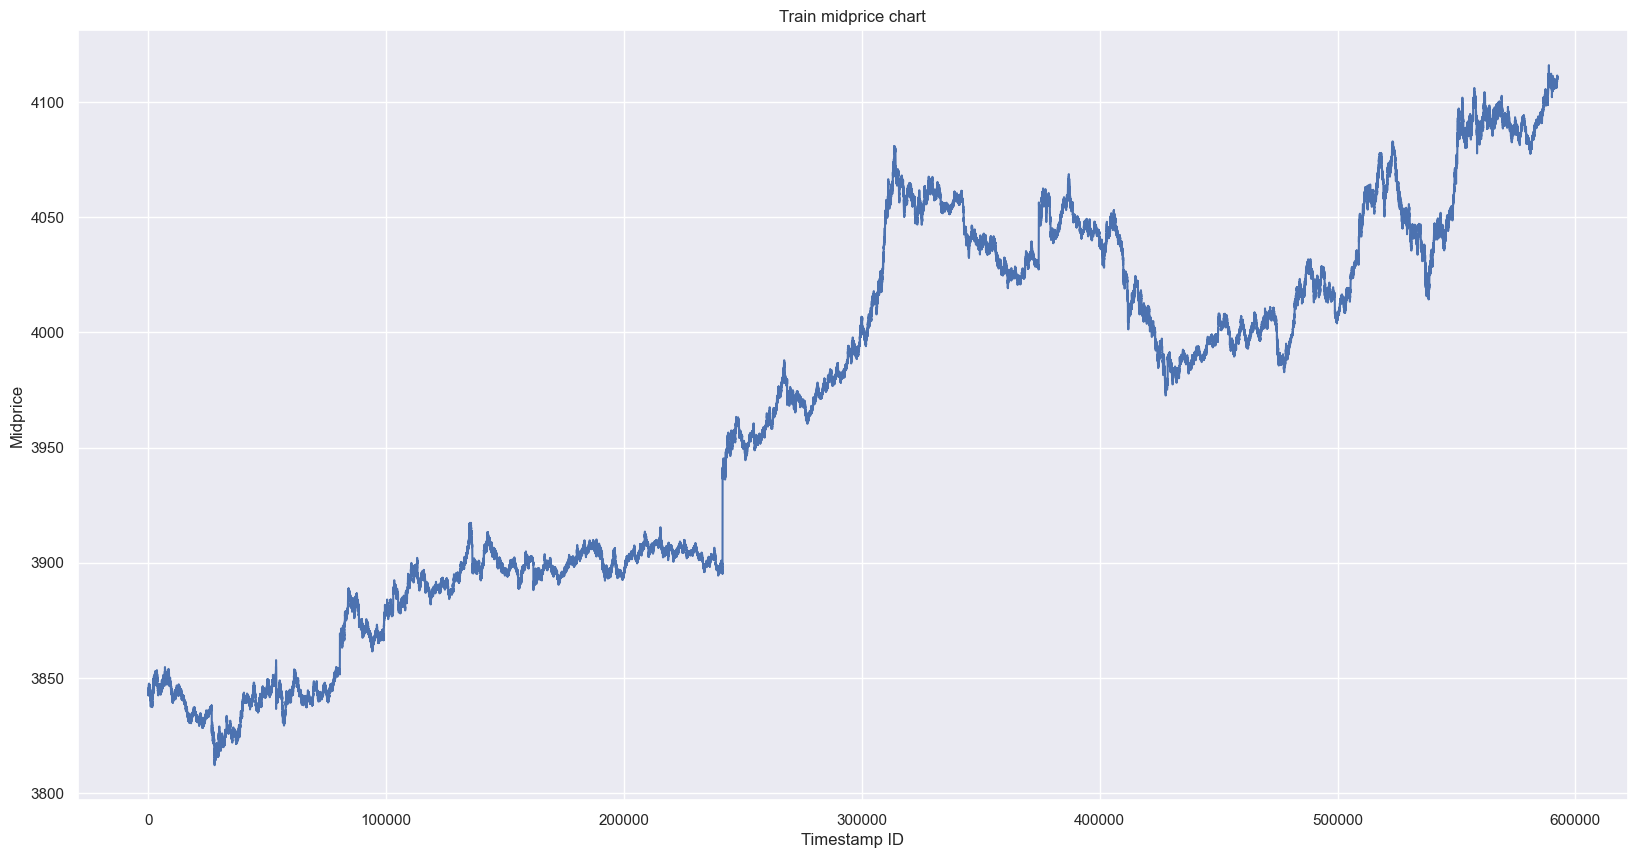

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(df_train.id, df_train.mid)
plt.title('Train midprice chart')
plt.xlabel('Timestamp ID')
plt.ylabel('Midprice')
plt.show()

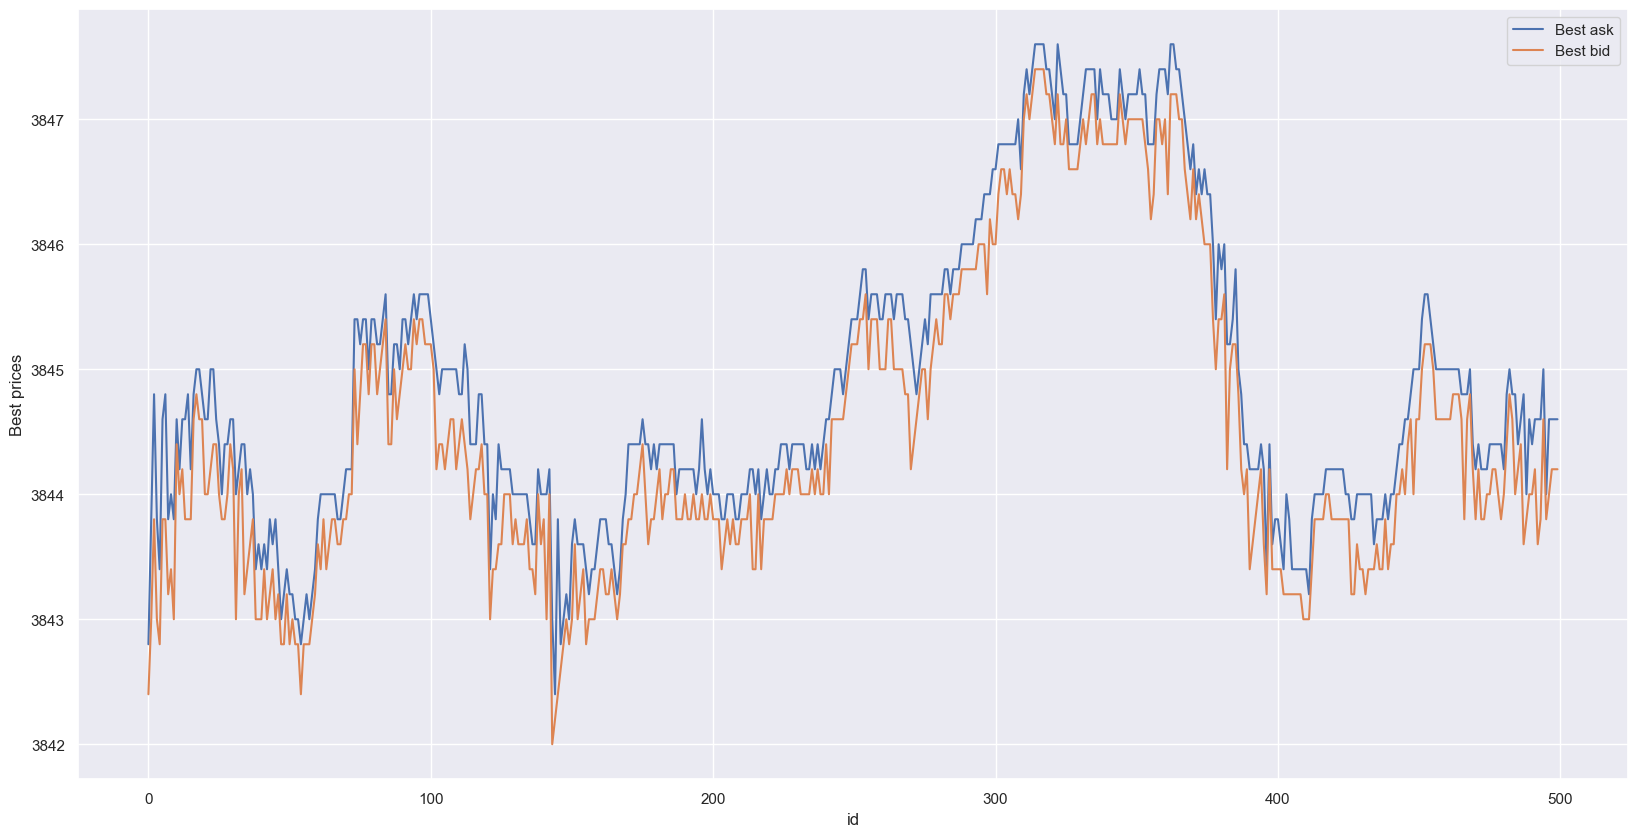

In [14]:
start_time_frame = 0
end_time_frame = 500
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(df_train.iloc[start_time_frame:end_time_frame], x='id', y='ask1', ax=ax, label='Best ask')
sns.lineplot(df_train.iloc[start_time_frame:end_time_frame], x='id', y='bid1', ax=ax, label='Best bid')
plt.ylabel('Best prices')
plt.show()

In [15]:
triple_target = np.sign(df_train.mid.diff(-2)).fillna(0)

In [16]:
((triple_target == -1) == y).mean()

0.9940072250920018

In [17]:
pd.DataFrame(triple_target).value_counts(normalize=True)

mid 
-1.0    0.350966
 1.0    0.349593
 0.0    0.299441
dtype: float64

In [18]:
train_snapshot_accessor = DataAccessor(df_train)
train_feats = Features.compute(train_snapshot_accessor)
train_feats.head()

,vimba,quote_vimba,vimba_2,vimba_3,vimba_4,vimba_5,bid_diff_1,bid_diff_2,bid_diff_3,bid_diff_4,ask_diff_1,ask_diff_2,ask_diff_3,ask_diff_4,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
0,0.571429,0.571403,0.562500,0.652174,0.617021,0.636364,0.4,0.2,0.8,0.6,-0.6,-0.2,-0.2,-0.2,0.4,0.4,0.0,NaN,0.000000
1,0.875000,0.874977,0.722222,0.727273,0.714286,0.574074,0.2,0.4,0.4,0.2,-0.2,-0.4,-0.2,-0.2,0.8,1.0,-0.2,0.109091,-0.781818
2,0.750000,0.749951,0.190476,0.228571,0.483333,0.506173,0.2,0.4,0.2,0.2,-0.2,-0.4,-0.2,-0.2,1.0,0.8,0.2,0.083333,-0.821429
3,0.833333,0.833304,0.718750,0.777778,0.755102,0.640625,0.2,0.4,0.4,0.6,-0.2,-0.4,-0.2,-0.2,0.8,0.0,0.8,0.081081,-0.810811
4,0.933333,0.933324,0.866667,0.848485,0.652174,0.523077,0.4,0.4,0.2,0.4,-0.6,-0.6,-0.2,-0.2,0.6,0.2,0.4,0.073171,-0.853659


In [19]:
test_snapshot_accessor =  DataAccessor(df_test)
test_feats = Features.compute(test_snapshot_accessor)
test_feats.head()

,vimba,quote_vimba,vimba_2,vimba_3,vimba_4,vimba_5,bid_diff_1,bid_diff_2,bid_diff_3,bid_diff_4,ask_diff_1,ask_diff_2,ask_diff_3,ask_diff_4,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
0,0.750000,0.749993,0.791667,0.785714,0.676471,0.648649,0.2,0.2,0.2,0.2,-0.2,-0.2,-0.2,-0.8,0.2,0.0,0.2,0.083333,-0.833333
1,0.200000,0.199994,0.200000,0.277778,0.300000,0.516129,0.2,0.2,0.2,0.2,-0.2,-0.6,-0.2,-0.2,0.2,0.0,0.2,1.000000,1.000000
2,0.533333,0.533256,0.702703,0.692308,0.666667,0.641509,0.4,0.2,0.2,0.4,-0.2,-0.2,-0.2,-0.2,1.6,1.4,0.2,1.000000,1.000000
3,0.888889,0.888862,0.866667,0.566667,0.512821,0.500000,0.2,0.2,0.6,0.2,-0.2,-0.2,-0.2,-0.2,1.4,1.0,0.4,0.000000,-0.500000
4,0.250000,0.249971,0.545455,0.538462,0.526316,0.500000,0.2,0.2,0.2,0.2,-1.0,-0.2,-0.2,-0.2,0.8,0.4,0.4,NaN,NaN


In [20]:
train_feats.describe()

,vimba,quote_vimba,vimba_2,vimba_3,vimba_4,vimba_5,bid_diff_1,bid_diff_2,bid_diff_3,bid_diff_4,ask_diff_1,ask_diff_2,ask_diff_3,ask_diff_4,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
count,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,592380.000000,419920.000000,419942.000000
mean,0.498875,0.498856,0.500492,0.501774,0.502459,0.502739,0.237832,0.223863,0.221647,0.220879,-0.238686,-0.225385,-0.222961,-0.222117,0.384431,0.191762,0.192669,0.372631,-0.008380
std,0.235983,0.235982,0.200467,0.177683,0.166505,0.160499,0.101037,0.079855,0.075508,0.075096,0.102133,0.080938,0.077576,0.076783,0.203889,0.235759,0.235628,0.373718,0.657399
min,0.009901,0.009900,0.015625,0.025424,0.031447,0.041096,0.200000,0.200000,0.200000,0.200000,-3.200000,-2.200000,-1.600000,-1.600000,0.200000,-1.800000,-2.600000,0.000000,-1.000000
25%,0.333333,0.333298,0.333333,0.368421,0.380000,0.384615,0.200000,0.200000,0.200000,0.200000,-0.200000,-0.200000,-0.200000,-0.200000,0.200000,0.000000,0.000000,0.000000,-0.500000
50%,0.500000,0.499975,0.500000,0.500000,0.500000,0.500000,0.200000,0.200000,0.200000,0.200000,-0.200000,-0.200000,-0.200000,-0.200000,0.400000,0.200000,0.200000,0.333333,0.000000
75%,0.666667,0.666656,0.666667,0.636364,0.625000,0.622222,0.200000,0.200000,0.200000,0.200000,-0.200000,-0.200000,-0.200000,-0.200000,0.600000,0.400000,0.400000,0.666667,0.500000
max,0.990000,0.990000,0.983333,0.979866,0.967742,0.956989,2.800000,3.400000,2.200000,2.200000,-0.200000,-0.200000,-0.200000,-0.200000,4.200000,3.800000,4.000000,1.000000,1.000000


In [21]:
test_feats.describe()

,vimba,quote_vimba,vimba_2,vimba_3,vimba_4,vimba_5,bid_diff_1,bid_diff_2,bid_diff_3,bid_diff_4,ask_diff_1,ask_diff_2,ask_diff_3,ask_diff_4,spread,last_take_ask_diff,last_take_bid_diff,interest_imbalance,open_interest_imbalance
count,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,191859.000000,138203.000000,138210.000000
mean,0.498269,0.498247,0.497468,0.495682,0.494213,0.492387,0.323893,0.301300,0.297652,0.296597,-0.322735,-0.300358,-0.296421,-0.295981,0.576757,0.287206,0.289551,0.386622,0.018179
std,0.218727,0.218727,0.195440,0.179034,0.168673,0.162684,0.217236,0.188974,0.185208,0.184817,0.215459,0.190258,0.188692,0.188209,0.352807,0.382409,0.381505,0.372083,0.648227
min,0.010204,0.010204,0.019608,0.020619,0.033058,0.028986,0.200000,0.200000,0.200000,0.200000,-3.000000,-3.000000,-3.000000,-3.000000,0.200000,-2.800000,-2.800000,0.000000,-1.000000
25%,0.333333,0.333308,0.333333,0.363636,0.370370,0.375000,0.200000,0.200000,0.200000,0.200000,-0.400000,-0.400000,-0.400000,-0.400000,0.200000,0.000000,0.000000,0.000000,-0.500000
50%,0.500000,0.499971,0.500000,0.500000,0.500000,0.500000,0.200000,0.200000,0.200000,0.200000,-0.200000,-0.200000,-0.200000,-0.200000,0.600000,0.200000,0.200000,0.333333,0.000000
75%,0.666667,0.666649,0.647059,0.625000,0.615385,0.611111,0.400000,0.400000,0.400000,0.400000,-0.200000,-0.200000,-0.200000,-0.200000,0.800000,0.600000,0.600000,0.666667,0.500000
max,0.990196,0.990195,0.983193,0.970370,0.957895,0.948454,6.400000,3.000000,3.000000,3.200000,-0.200000,-0.200000,-0.200000,-0.200000,5.800000,4.400000,6.200000,1.000000,1.000000


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train_feats, y, test_size=0.3, shuffle=False)

X_train.dropna(inplace=True)
y_train = y_train.loc[X_train.index]
X_test.dropna(inplace=True)
y_test = y_test.loc[X_test.index]

lm_clf = LogisticRegression()
lm_clf.fit(X_train, y_train)

y_test_pred_proba = lm_clf.predict_proba(X_test)[:, 1]
y_train_pred_proba = lm_clf.predict_proba(X_train)[:, 1]

print('train score:', roc_auc_score(y_train, y_train_pred_proba))
print('test score:', roc_auc_score(y_test, y_test_pred_proba))

train score: 0.6570729215453669
test score: 0.6483971880026164


  0%|          | 0/19 [00:00<?, ?it/s]

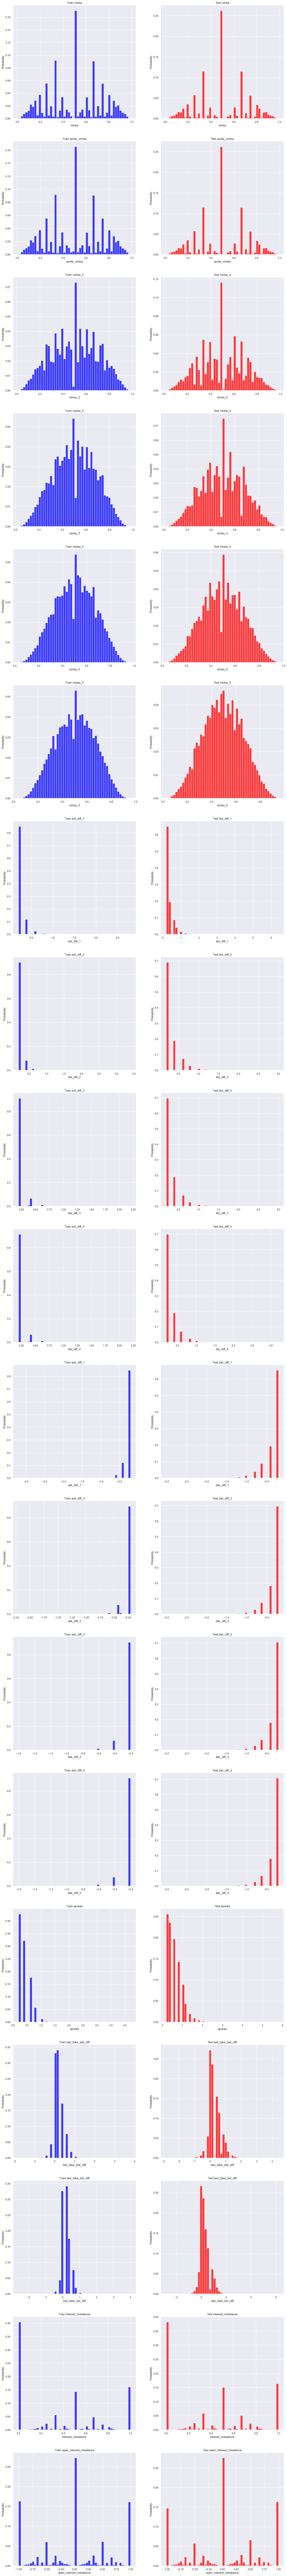

In [28]:
fig, axs = plt.subplots(train_feats.shape[1], 2, figsize=(20, train_feats.shape[1] * 10))

for i, feat in enumerate(tqdm(train_feats.columns)):
    sns.histplot(train_feats[feat], color="blue", ax=axs[i, 0], bins=50, stat='probability').set(title=f'Train {feat}')
    sns.histplot(test_feats[feat], color="red", ax=axs[i, 1], bins=50, stat='probability').set(title=f'Test {feat}')

plt.show()

In [30]:
kspvalues = {feat : kstest(train_feats[feat], test_feats[feat]).pvalue for feat in train_feats.columns}

In [33]:
pd.DataFrame(kspvalues, index=['KS-test pvalue']).T

,KS-test pvalue
vimba,1.047806e-277
quote_vimba,0.000000e+00
vimba_2,1.264308e-104
vimba_3,4.096714e-110
vimba_4,8.656973e-145
vimba_5,1.657570e-167
bid_diff_1,0.000000e+00
bid_diff_2,0.000000e+00
bid_diff_3,0.000000e+00
bid_diff_4,0.000000e+00


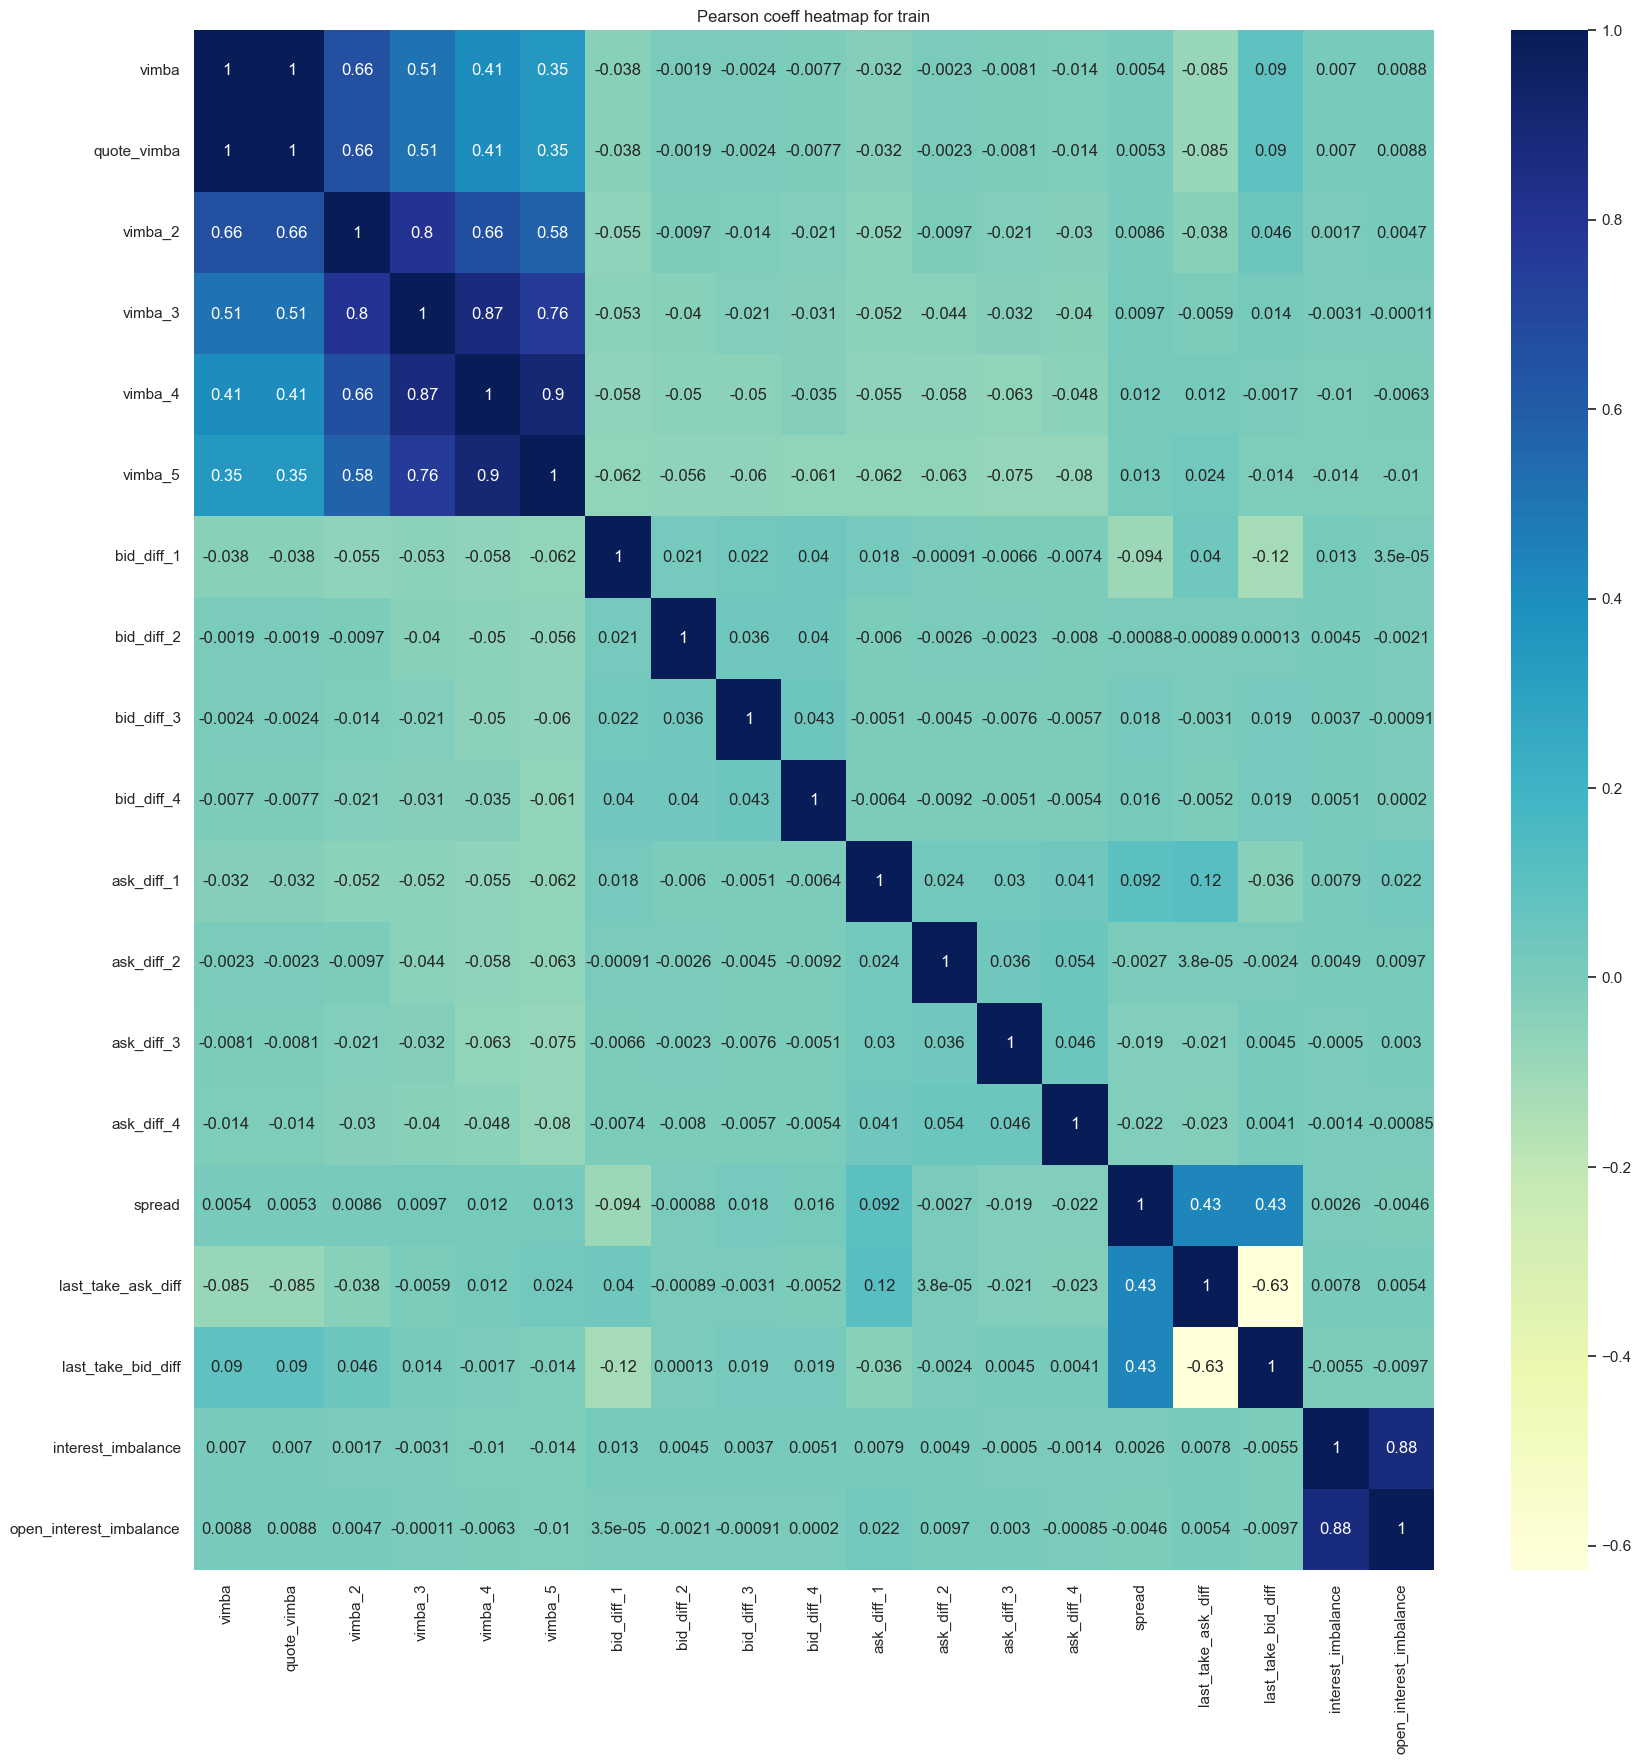

In [40]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_feats.corr(), cmap="YlGnBu", annot=True, ax=ax).set(title='Pearson coeff heatmap for train')
plt.show()

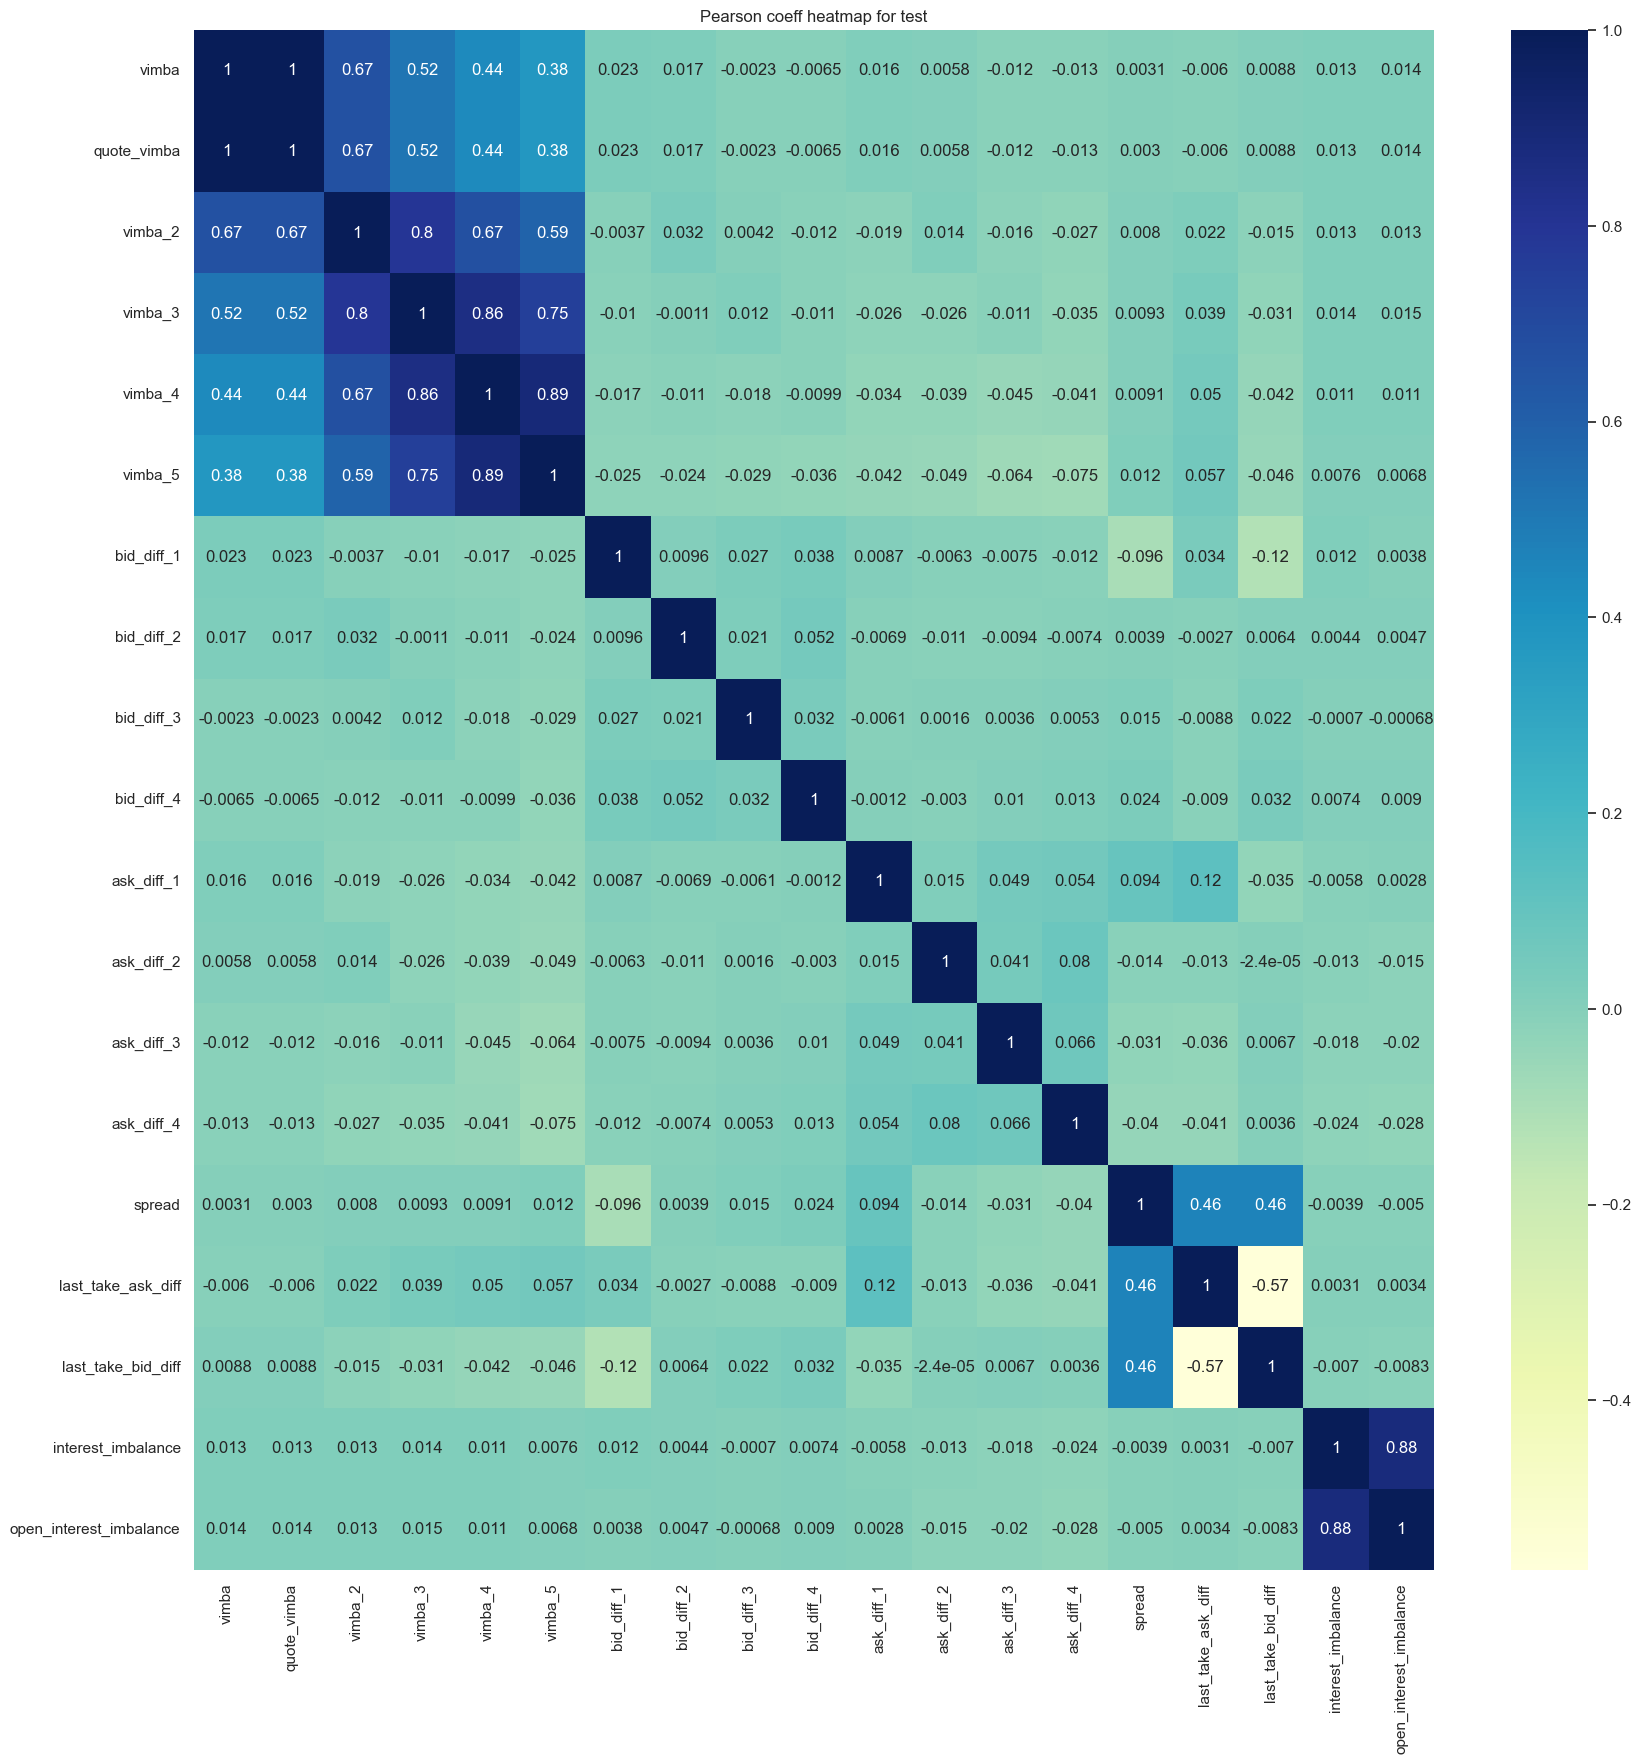

In [41]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(test_feats.corr(), cmap="YlGnBu", annot=True, ax=ax).set(title='Pearson coeff heatmap for test')
plt.show()

In [76]:
boost_clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.02,
    depth=3,
    logging_level='Verbose',
    thread_count=5,
    task_type='CPU'
)

In [77]:
boost_clf.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6905578	test: 0.6907606	best: 0.6907606 (0)	total: 16.8ms	remaining: 16.8s
1:	learn: 0.6880883	test: 0.6884832	best: 0.6884832 (1)	total: 43.7ms	remaining: 21.8s
2:	learn: 0.6857442	test: 0.6863418	best: 0.6863418 (2)	total: 59.2ms	remaining: 19.7s
3:	learn: 0.6834270	test: 0.6842211	best: 0.6842211 (3)	total: 74.4ms	remaining: 18.5s
4:	learn: 0.6812083	test: 0.6821950	best: 0.6821950 (4)	total: 90.4ms	remaining: 18s
5:	learn: 0.6790800	test: 0.6802541	best: 0.6802541 (5)	total: 106ms	remaining: 17.5s
6:	learn: 0.6771698	test: 0.6784965	best: 0.6784965 (6)	total: 122ms	remaining: 17.4s
7:	learn: 0.6752916	test: 0.6767754	best: 0.6767754 (7)	total: 138ms	remaining: 17.1s
8:	learn: 0.6734168	test: 0.6750691	best: 0.6750691 (8)	total: 153ms	remaining: 16.9s
9:	learn: 0.6716122	test: 0.6734365	best: 0.6734365 (9)	total: 170ms	remaining: 16.8s
10:	learn: 0.6699308	test: 0.6719133	best: 0.6719133 (10)	total: 186ms	remaining: 16.7s
11:	learn: 0.6683141	test: 0.6704461	best: 0.6704

In [78]:
roc_auc_score(y_train, boost_clf.predict_proba(X_train)[:, 1])

0.6666395311922029

In [79]:
roc_auc_score(y_test, boost_clf.predict_proba(X_test)[:, 1])

0.6550077349543153

In [57]:
boost_clf = CatBoostClassifier(
    iterations=30,
    learning_rate=0.3,
    eval_metric='AUC:hints=skip_train~false',
    logging_level='Silent',
    thread_count=5,
    task_type='CPU',
)

params = {
    'langevin': [True, False], 
    'diffusion_temperature': np.arange(9000, 11000, 1000),
    'posterior_sampling': [True, False], 
    'score_function': ['Cosine', 'L2'],
    'model_shrink_mode': ['Decreasing', 'Constant'],
    'random_strength': np.arange(0.5, 0.76, 0.25),
    'depth': np.arange(3, 7),
    'has_time': [True, False]
}

boost_clf.grid_search(params, X=X_train, y=y_train, cv=5)

0:	loss: 0.6637310	best: 0.6637310 (0)	total: 823ms	remaining: 7m
1:	loss: 0.6637310	best: 0.6637310 (0)	total: 1.64s	remaining: 6m 59s
2:	loss: 0.6645374	best: 0.6645374 (2)	total: 2.49s	remaining: 7m 2s
3:	loss: 0.6645374	best: 0.6645374 (2)	total: 3.31s	remaining: 6m 59s
4:	loss: 0.6654957	best: 0.6654957 (4)	total: 4.13s	remaining: 6m 58s
5:	loss: 0.6654957	best: 0.6654957 (4)	total: 4.96s	remaining: 6m 58s
6:	loss: 0.6647447	best: 0.6654957 (4)	total: 5.91s	remaining: 7m 6s
7:	loss: 0.6647447	best: 0.6654957 (4)	total: 6.81s	remaining: 7m 9s
8:	loss: 0.6637985	best: 0.6654957 (4)	total: 7.47s	remaining: 6m 57s
9:	loss: 0.6637985	best: 0.6654957 (4)	total: 8.15s	remaining: 6m 49s
10:	loss: 0.6645227	best: 0.6654957 (4)	total: 8.89s	remaining: 6m 45s
11:	loss: 0.6645227	best: 0.6654957 (4)	total: 9.62s	remaining: 6m 40s
12:	loss: 0.6650381	best: 0.6654957 (4)	total: 10.4s	remaining: 6m 39s
13:	loss: 0.6650381	best: 0.6654957 (4)	total: 11.2s	remaining: 6m 38s
14:	loss: 0.6654325	bes

{'params': {'langevin': True,
  'has_time': True,
  'posterior_sampling': False,
  'diffusion_temperature': 9000,
  'depth': 6,
  'random_strength': 0.5,
  'score_function': 'L2',
  'model_shrink_mode': 'Constant'},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29],
              'test-AUC-mean': [0.6474310483425478,
               0.6551278755928923,
               0.6577690721314744,
               0.6594394732339613,
               0.66

In [71]:
params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'eval_metric': 'AUC:hints=skip_train~false',
    'logging_level': 'Silent',
    'thread_count': 5,
    'task_type': 'CPU',
    'langevin': True,
    'has_time': True,
    'posterior_sampling': False,
    'diffusion_temperature': 9000,
    'depth': 6,
    'random_strength': 0.5,
    'score_function': 'L2',
    'model_shrink_mode': 'Constant'
}

boost_clf = CatBoostClassifier(**params)

In [72]:
boost_clf.fit(X_train, y_train)

In [73]:
roc_auc_score(y_train, boost_clf.predict_proba(X_train)[:, 1])

0.675630949032039

In [74]:
roc_auc_score(y_test, boost_clf.predict_proba(X_test)[:, 1])

0.6566209262183045